### Quote rate trends  
### Are service providers in matchmaking online markets becoming more or less inclined to quote over time?

Data:

<li>categories and locations store the names of all categories and locations
<li>users holds the user ID and email for all users, both consumers and service providers
<li>requests has a row for each request posted by a consumer
    user_id references the consumer who posted the request
    category_id and location_id reference the categories and locations tables for the category
    and location of the request creation_time is when the consumer posted the request
<li>invites has a row for each invite sent to a service provider
    request_id references the request that this invite was sent for
    user_id references the service provider that this invite was sent to
    sent_time is when the invite was sent to the service provider
<li>quotes has a row for each quote a service provider sent in response to an invite
    invite_id references the invite that this quote was sent in response to
    sent_time is when the service provider sent the quote

References:

https://plot.ly/python/big-data-analytics-with-pandas-and-sqlite/


In [3]:
import pandas as pd
import numpy as np
import sqlite3
from scipy import stats
from plotly.graph_objs import Data, Line

import time, sys
import matplotlib
# huge images can't be displayed on a screen, so directly use Agg
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.mlab import csv2rec
from matplotlib.cbook import get_sample_data
#Plotting by seaborn
import seaborn as sns
from datetime import datetime


def get_QIR_daily_per_category(fulldf):
    """
    Returns a single df (datepoint, category, QIR)
    """
    sub_df = fulldf.copy()
    datepoints = list(set(fulldf.datepoint))
    rows = []
    # create an extra column per category with its QIR over time
    for c,cat_df in sub_df.groupby('category'):
        for datepoint in set(cat_df.datepoint):
            row = {}
            df = cat_df[cat_df.datepoint==datepoint]#cat_df[cat_df['datepoint'] == datepoint]
            if not df.empty:
                row['datepoint'] = datepoint
                row['category'] = c
                if df.invite_dt.count()>0:
                    row['QIR'] = np.divide(float(df.quote_dt.count()), df.invite_dt.count())
                else:
                    row['QIR'] = 0
                rows.append(row)
    return pd.DataFrame(pd.DataFrame(rows))


def get_quote_per_invite_rate_daily(fulldf, categories = []):
    """
    If no categories are provided, the average QIR is provided per day averaging over all categories
    otherwise returns a list of df (datepoint, category_name_QIR)
    """
    sub_df = fulldf.copy()
    list_of_dfs = []
    datepoints = list(set(fulldf.datepoint))
    # new df rows:
    rows = []
    if len(categories) == 0: 
        #we compute average QIR for all categories per day:
        for datepoint in datepoints:
            # getting invites sub dataframe
            df = sub_df[sub_df['datepoint']== datepoint]
            if not df.empty:
                if df.invite_dt.count()>0:
                    QIR = np.divide(float(df.quote_dt.count()), df.invite_dt.count())
                    rows.append({'datepoint':datepoint, 'QIR': QIR})
                else: 
                    rows.append({'datepoint':datepoint, 'QIR': 0})
            else:
                rows.append({'datepoint':datepoint, 'QIR': 0}) 
        list_of_dfs.append(pd.DataFrame(rows))
    else:
        # create an extra column per category with its QIR over time
        for cat in categories:
            column_name = cat+'_QIR'
            cat_df = sub_df[sub_df['category'] == cat]
            datepoints = set(cat_df.datepoint.values)
            for datepoint in datepoints:
                row = {}
                df = cat_df[cat_df['datepoint'] == datepoint]
                if not df.empty:
                    row['datepoint'] = datepoint
                    row['category'] = cat
                    if not df.empty:
                        if df.invite_dt.count()>0:
                            row[column_name] = np.divide(float(df.quote_dt.count()), df.invite_dt.count())
                        else:
                            row[column_name] = 0
                    else:
                        row[column_name] = 0
                    rows.append(row)
            final = pd.DataFrame(rows)#.set_index(['datepoint'])   
            list_of_dfs.append(final)
            #print "sizes of final df: ",len(final), " unique days: " , final.datepoint.nunique()
    return list_of_dfs#   return pd.DataFrame(QIR_all_cats)

def subsample_lists(df, everyNth):
    # a: set_markevery(every)
    # b: by a factor: idx = np.random.choice(np.arange(len(df)), num_samples)
    # plt.scatter(df[idx], df[idx])
    # c: starting from pos 0 until the end, taking every 4th row  #numpy slicing for subsumpling the data: start:stop:step.
    return df.copy()[0::everyNth] 

def datetime2str(dt_obj):
    # conversions of datetime object to string
    #dt_obj = datetime(2008, 11, 10, 17, 53, 59)
    date_str = dt_obj.strftime("%Y-%m-%d %H:%M:%S")
    print type(date_str)
    return date_str

    # time tuple to string
    time_tuple = (2008, 11, 12, 13, 51, 18, 2, 317, 0)
    date_str = time.strftime("%Y-%m-%d %H:%M:%S", time_tuple)
    print type(date_str)

def change_datetime_format(dt_obj, new_format = "%Y-%m-%d"):
    dt = dt_obj.apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S").strftime(new_format))
    return dt

def make_column_binary(df, column):
    df[column] = df[column].apply(lambda x: 1 if isinstance(x, datetime.datetime) 
                                       and not isinstance(x, pd.tslib.NaTType) else 0)
    return df


# Create a SQL connection to our SQLite database
#con = sqlite3.connect("data/db.sqlite")
#cur = con.cursor()
# the result of a "cursor.execute" can be iterated over by row
#for row in cur.execute('SELECT * FROM species;'):
#    print(row)

# Read sqlite query results into a pandas DataFrame
db = "data/invite_dataset_ff829852.sqlite"
con = sqlite3.connect(db)

categories = pd.read_sql_query("SELECT * from categories", con)
locations = pd.read_sql_query("SELECT * from locations", con)
users = pd.read_sql_query("SELECT * from users", con)
requests = pd.read_sql_query("SELECT * from requests", con)
invites = pd.read_sql_query("SELECT * from invites", con)
quotes = pd.read_sql_query("SELECT * from quotes", con)

# verify that result of SQL query is stored in the dataframe
print(categories.head())
print(locations.head())
print(users.head())
print(requests.head())
print(invites.head())
print(quotes.head())
print "Requests, Invites and Quotes total: ", len(requests)," ", len(invites)," ", len(quotes)

   category_id                      name
0            1               Photography
1            2       Window Installation
2            3      Portrait Photography
3            4              Wedding Band
4            5  Home Security and Alarms
   location_id                                   name
0            1  New York-Newark-Jersey City, NY-NJ-PA
1            2     Los Angeles-Long Beach-Anaheim, CA
2            3     Chicago-Naperville-Elgin, IL-IN-WI
3            4        Dallas-Fort Worth-Arlington, TX
4            5   Houston-The Woodlands-Sugar Land, TX
   user_id                 email
0        1    william@idxydp.com
1        2    william@dhgtae.com
2        3       liam@aqpvfh.com
3        4  elizabeth@hpgruv.com
4        5   isabella@omwtoj.com
   request_id  user_id  category_id  location_id               creation_time
0           1     1001           46           35  2013-07-01 07:48:54.000000
1           2     1002           83           19  2013-07-01 04:55:25.000000
2

In [4]:
import datetime as dt
from IPython.display import display  #from sqlalchemy import create_engine
import plotly.plotly as py # interactive graphing
from plotly.graph_objs import Bar, Scatter, Marker, Layout 
import plotly.graph_objs as go
import datetime
import plotly.plotly as py
#from plotly.graph_objs import *
#py.sign_in('username', 'api_key')

#disk_engine = create_engine(db)
request_category_counts = pd.read_sql_query('SELECT c.name as `category`, COUNT(*) as `num_requests`, creation_time, user_id '
                       'FROM requests '
                       'JOIN categories c ON c.category_id = requests.category_id '
                       'GROUP BY `category` '
                       'ORDER BY -num_requests', con)
 
py.iplot({
    'data': [Bar(x=request_category_counts['category'], y=request_category_counts.num_requests)],
    'layout': { 
        'margin': {'b': 200}, # Make the bottom margin a bit bigger to handle the long text
        'xaxis': {'title': 'Category', 'tickangle': 40}, # Angle the labels a bit
        'yaxis': {'title': 'Number of Requests'},
        'title': 'Number of service requests per category'
    }}, filename='Requests_per_category')    

Looking at the different most demanded service categories per location (and per category resp), we can graphically see the service categories (resp. locations) that may require more marketing attention to bring more service providers 
in that domain and to bring them to that location. We can also see for which categories we have a more imbalanced dat set with respect to others.

In [5]:
request_location_counts = pd.read_sql_query('SELECT l.name as `location`, COUNT(*) as `num_requests`, creation_time, user_id '
                       'FROM requests '
                       'JOIN locations l ON l.location_id = requests.location_id '
                       'GROUP BY `location` '
                       'ORDER BY -num_requests', con)

py.iplot({
    'data': [Bar(x=request_location_counts['location'], y=request_location_counts.num_requests)],
    'layout': { 
        'margin': {'b': 200}, # Make the bottom margin a bit bigger to handle the long text
        'xaxis': {'title': 'Locations','tickangle': 40}, # Angle the labels a bit
        'yaxis': {'title': 'Number of Requests'},
        'title': 'Number of service requests per location'
    }}, filename='Requests_per_location')


In [6]:
category_types = list(set(categories.name))
traces = [] # the series in the graph - one trace for each category
                       
for cat in category_types:
    df = pd.read_sql_query('SELECT l.name as `location`, c.name as `category`, COUNT(*) as `num_requests`, request_id '
                           'FROM requests '
                           'JOIN locations l ON l.location_id = requests.location_id '
                           'JOIN categories c ON c.category_id = requests.category_id '
                           'WHERE c.name = "{}" COLLATE NOCASE '
                           'GROUP BY `location` '
                           'ORDER BY -num_requests'.format(cat), con)

    traces.append(Bar(x=df['location'], y=df.num_requests, name=cat.capitalize()))
py.iplot({'data': traces, 'layout': {
            'margin': {'b': 200}, # Make the bottom margin a bit bigger to handle the long text
            'barmode': 'stack', 
            'xaxis':{'title': 'Location', 'tickangle': 40},
            'yaxis':{'title': 'Number of Complaints'},
            'title': 'Most common service request categories per location',
            'showlegend':False,
        }}, filename='requests_per_category_and_location')
print len(df), df.head()

22                                     location category  num_requests  \
0      New York-Newark-Jersey City, NY-NJ-PA   Tiling             9   
1         Los Angeles-Long Beach-Anaheim, CA   Tiling             8   
2          Atlanta-Sandy Springs-Roswell, GA   Tiling             3   
3       Houston-The Woodlands-Sugar Land, TX   Tiling             3   
4  Miami-Fort Lauderdale-West Palm Beach, FL   Tiling             2   

   request_id  
0        4697  
1        4701  
2        3713  
3        4850  
4        4231  


### The diversity in colours can give us a visually vast idea of whether the population' sample was randomly collected. The colourfulness of the plot above shows no visually aparent bias in this concern. However, to measure the statistical evidence of the significance and precision of these conclusions, we can plot a confidence interval [5] with a margin of error for the quote rate in each category (see boxplot at end of notebook)

In [7]:
traces = [] # the series in the graph - one trace for each category
data = pd.read_sql_query('SELECT l.name as `location`, c.name as `category`, i.invite_id, i.sent_time as invite_t, q.sent_time as quote_t '
                           'FROM requests '
                           'JOIN locations l ON l.location_id = requests.location_id '
                           'JOIN categories c ON c.category_id = requests.category_id '
                           'JOIN invites i ON i.request_id = requests.request_id '
                           'LEFT JOIN quotes q ON q.invite_id = i.invite_id '
                           'ORDER BY invite_t', con)

#Be sure to close the connection.
#con.close()
                                 
data['invite_dt'] = pd.to_datetime(data['invite_t'])
data['datepoint'] = change_datetime_format(data['invite_t'])
data['quote_dt'] = pd.to_datetime(data['quote_t'])
data['Quote'] = data['quote_dt'].copy()
data = make_column_binary(data, 'Quote') # for our box plot on CI on the variability of data
data['Year'] = data.invite_dt.apply(lambda x: x.year)
data['Day'] = data.invite_dt.apply(lambda x: x.day) 
data['Month'] = data.invite_dt.apply(lambda x: x.month) #print data.Week_Number.nunique(), 

print data.Day.unique(), " unique day numbers sampled, ", data.Year.unique(), " unique years sampled and ", data.Month.unique(), " unique months sampled"
print len(data), 'total data points (requests) \n',data.head()
data.drop(['quote_t', 'invite_id', 'invite_t'],axis=1,inplace=True)
#print data.head()
alldata = data.copy()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]  unique day numbers sampled,  [2013]  unique years sampled and  [7 8 9]  unique months sampled
24622 total data points (requests) 
                                       location                category  \
0  Nashville-Davidson-Murfreesboro-Franklin, TN       Concrete Services   
1  Nashville-Davidson-Murfreesboro-Franklin, TN       Concrete Services   
2  Nashville-Davidson-Murfreesboro-Franklin, TN       Concrete Services   
3           Tampa-St. Petersburg-Clearwater, FL           Tree Trimming   
4               Dallas-Fort Worth-Arlington, TX  Swimming Pool Cleaning   

   invite_id                    invite_t                     quote_t  \
0        448  2013-07-01 00:24:04.742427                        None   
1        449  2013-07-01 00:53:02.050569  2013-07-01 03:51:48.955745   
2        450  2013-07-01 00:57:56.178822  2013-07-01 02:45:01.056568   
3        458  2013-07-01 01:16:20.

### The following plot provides the overall trends regarding quote to invite rate (QIR) over the whole time period provided

In [8]:
category_types = list(set(data.category))
all_days = data.Day.unique()
all_years = data.Year.unique()
all_months = data.Month.unique()

print len(category_types)," categories"
# computing the Quotes/Invites Rate: QIR
print "Total average invites and total quotes : ", data['invite_dt'].count() , " ", data['quote_dt'].count()
print "QIR average total  = ", np.divide(float(data['quote_dt'].count()), data['invite_dt'].count())


113  categories
Total average invites and total quotes :  24622   12819
QIR average total  =  0.520631955162


,QIR
datepoint,
2013-08-26,0.558045
2013-08-27,0.497854
2013-08-28,0.534247
2013-08-19,0.557303
2013-08-18,0.492806
2013-08-31,0.532258
2013-08-29,0.546512
2013-08-15,0.441103
2013-08-14,0.540839


Plotting QIR for dates from  2013-07-01  to  2013-09-02  for total days (datepoints):  64


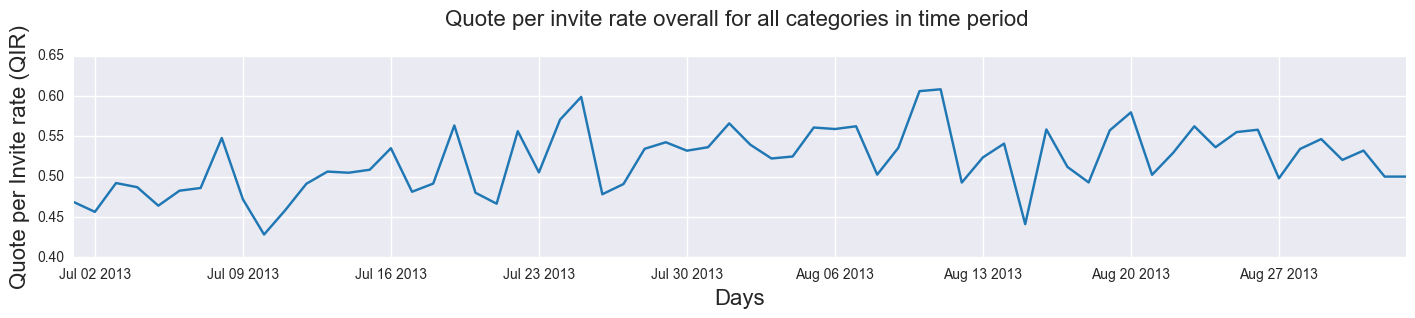

In [9]:
# Plot averages QIR per day
# These are the colors that will be used in the plot
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
color_index = 0   
QIR_daily = get_quote_per_invite_rate_daily(data)[0]   
QIR_daily.set_index(['datepoint'])

my_dpi = 192 #find your monitor dpi in http://www.infobyip.com/detectmonitordpi.php
# init the figure
fig_w, fig_h = 3300, 500 # pixels #2818285, 417 #33000, 500 # pixels
dpi=  100
fig = plt.figure(figsize=(float(fig_w)/float(my_dpi), float(fig_h)/float(my_dpi)), dpi=my_dpi, frameon=False)
sub_df = QIR_daily.copy().sort_values(by=['datepoint']) 

line = plt.plot_date(sub_df['datepoint'],
                sub_df['QIR'],
                '-', #for a continuous line, if we want to draw scatter plot of 'dots', use: #lw=2.5,
                color=color_sequence[color_index],
                label="Avg QIR per day")

interval_start = QIR_daily['datepoint'].min()
total_days = len(QIR_daily)
print "Plotting QIR for dates from ",interval_start," to ", QIR_daily['datepoint'].max(), " for total days (datepoints): ", total_days
plt.title('Quote per invite rate overall for all categories in time period \n', fontsize=16, ha='center')

# Finally, save the figure as a PNG.
# Just change the file extension in this call.plt.xlabel('xlabel', fontsize=18)
plt.ylabel("Quote per Invite rate (QIR)", fontsize=16)
plt.xlabel("Days", fontsize=16)
plt.savefig('general-quote-per-invite-rate-over-time.png')# Do not use: generates error below on too large image: bbox_inches='tight', dpi=1000)
#self._renderer = _RendererAgg(int(width), int(height), dpi, debug=False)
#ValueError: Image size of 5411109x802 pixels is too large. It must be less than 2^16 in each direction.
plt.show()


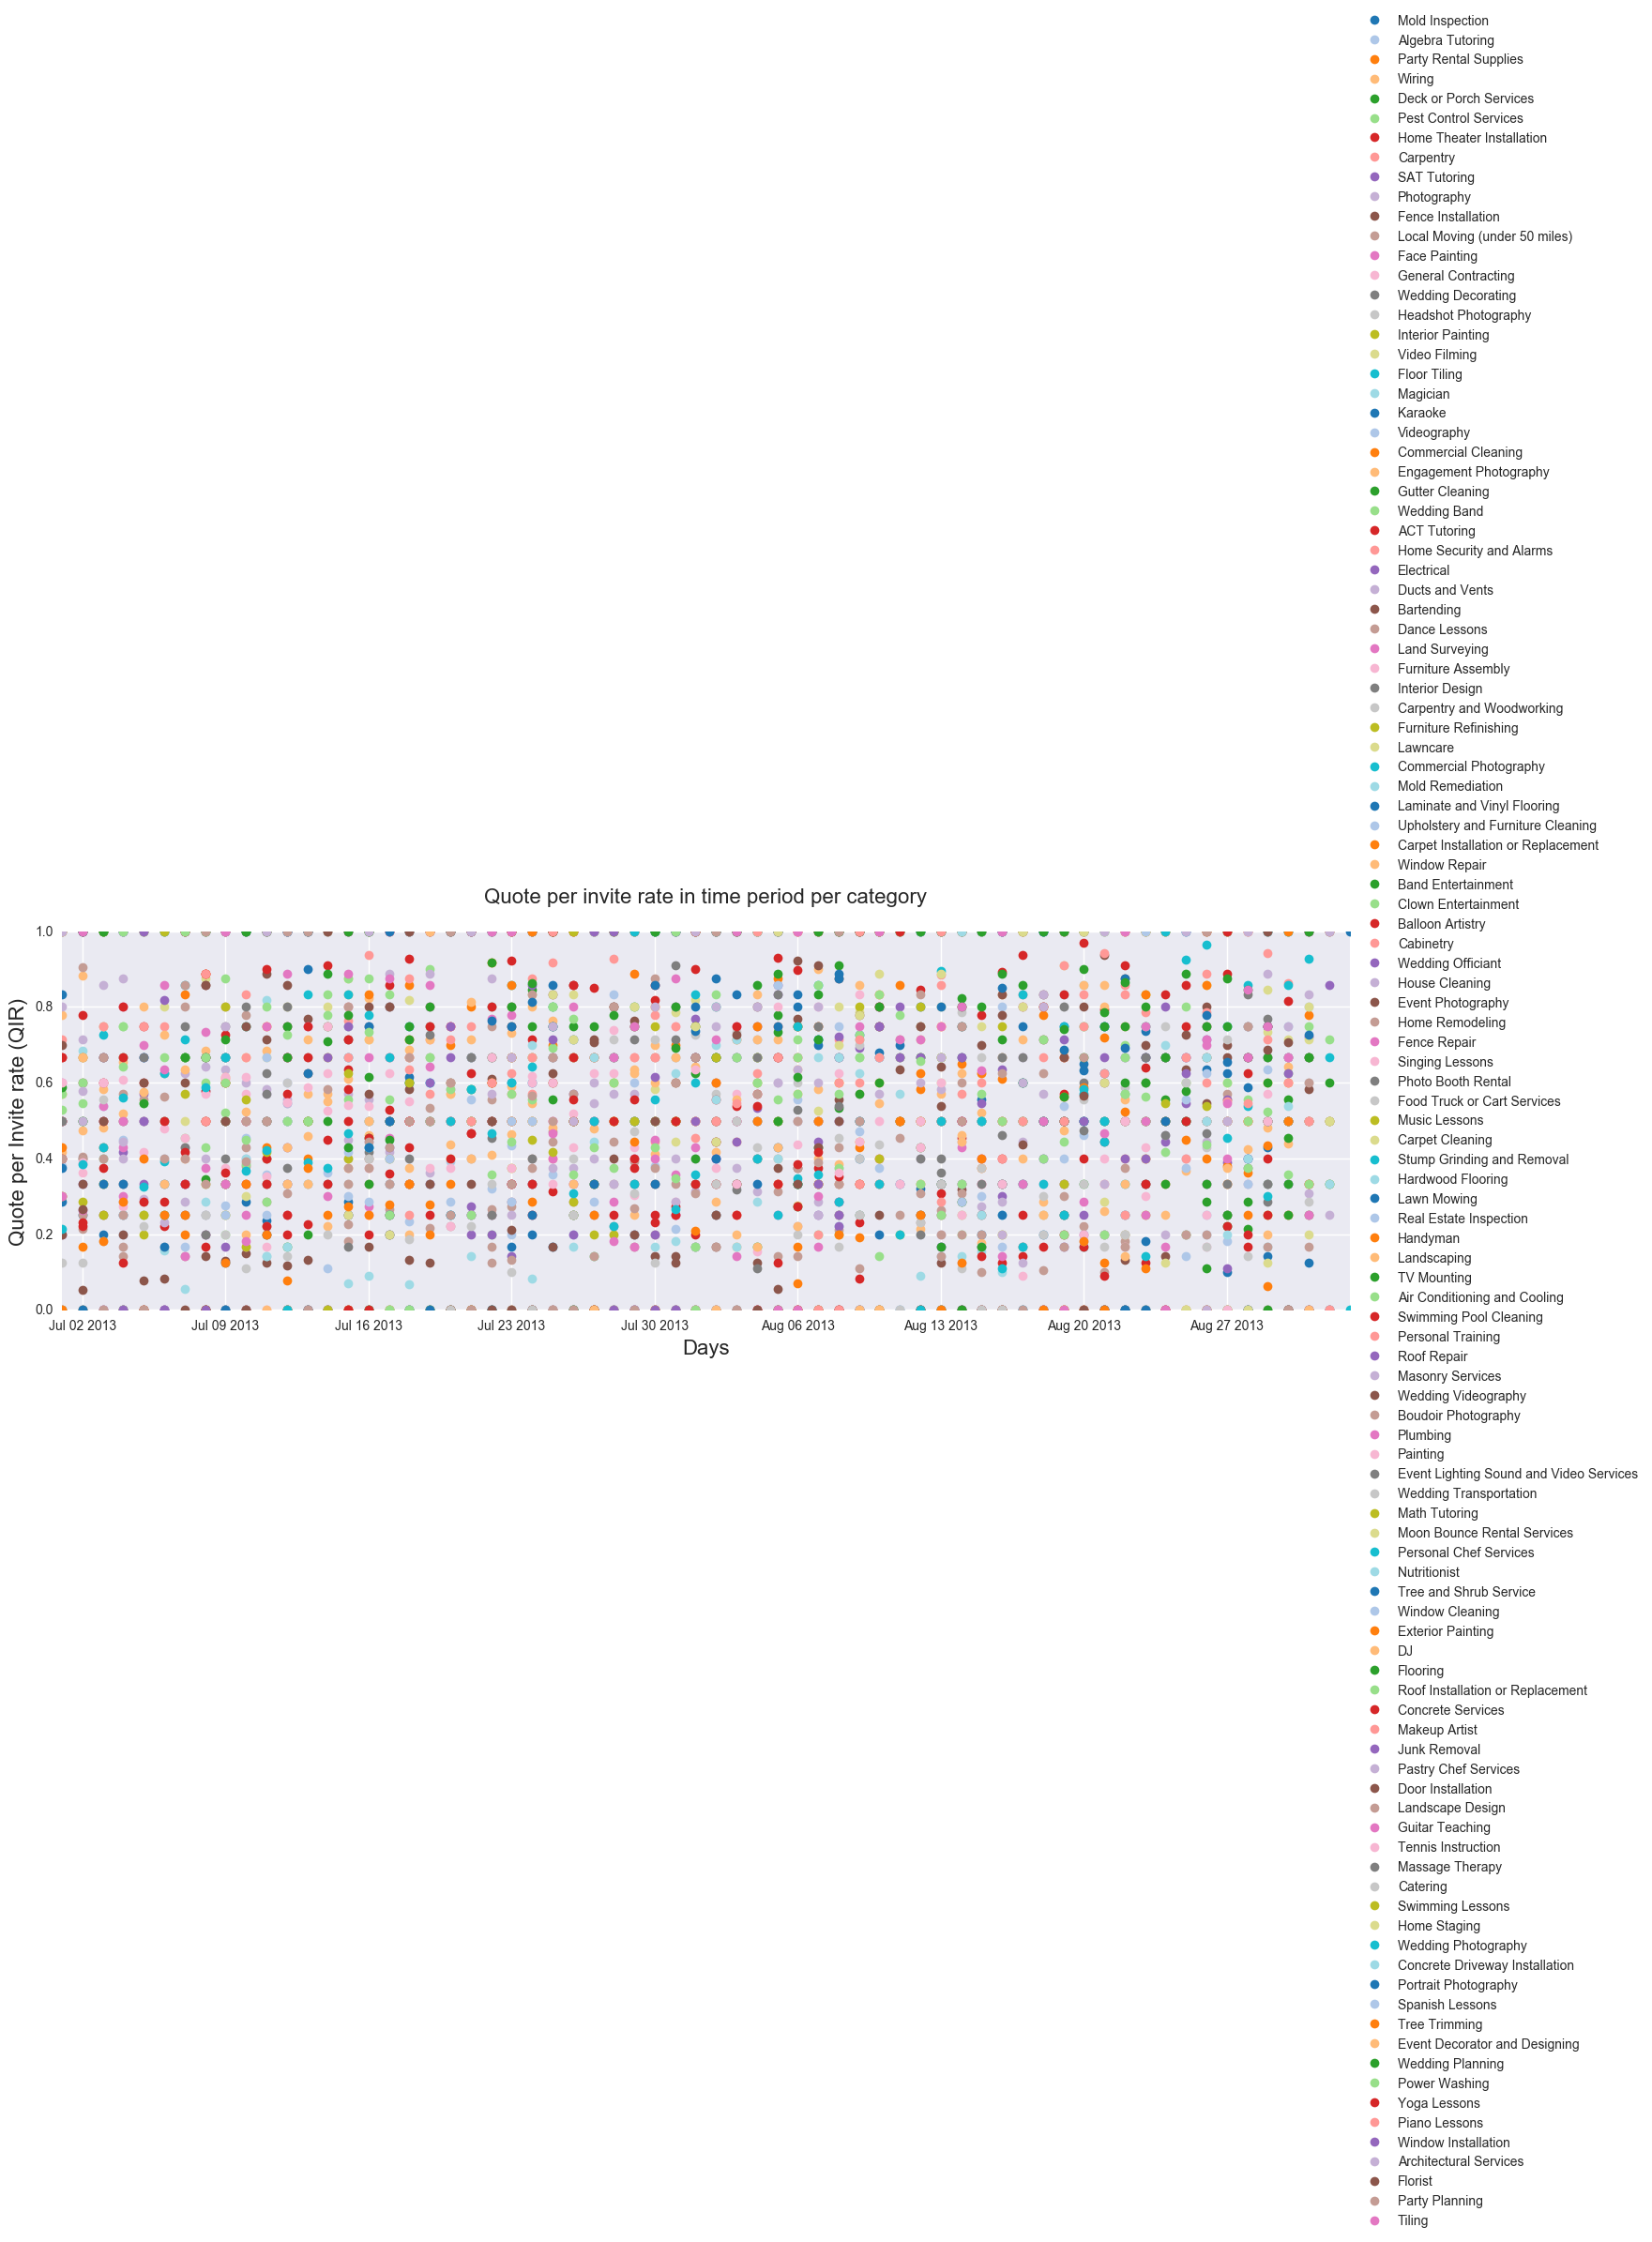

In [10]:
color_index = 0   
list_of_QIR_per_cat_dfs = get_quote_per_invite_rate_daily(data, categories = category_types)   

my_dpi = 192 #find your monitor dpi in http://www.infobyip.com/detectmonitordpi.php
# init the figure
fig_w, fig_h = 3400, 1000 # pixels
dpi=  100
fig = plt.figure(figsize=(float(fig_w)/float(my_dpi), float(fig_h)/float(my_dpi)), dpi=my_dpi, frameon=False)  
#print list_of_QIR_per_cat_dfs[0].head()
for i, cat in enumerate(category_types):
    # Plot each line separately with its own color.
    column_name = cat+'_QIR'
    cat_df = list_of_QIR_per_cat_dfs[i].sort_values(by=['datepoint'])#sub_df = df.copy().sort_values(by=['datepoint']) 
    line = plt.plot_date(cat_df['datepoint'],
            cat_df[column_name],
            #'-', #for a continuous line, if we want to draw scatter plot of 'dots', use: #lw=2.5,
            color=color_sequence[color_index],
            fmt='bo', 
            tz=None, xdate=True, 
            ydate=False, 
            label=cat)
    color_index +=1
    if color_index == len(color_sequence):
        color_index = 0

plt.title('Quote per invite rate in time period per category\n', fontsize=16, ha='center')
plt.ylabel("Quote per Invite rate (QIR)", fontsize=16)
plt.xlabel("Days", fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),shadow=True)

plt.savefig('quote-per-invite-rate-over-time-per-category_dots_fmt_bo.png')# Do not use: generates error below on too large image: bbox_inches='tight', dpi=1000)
plt.show()

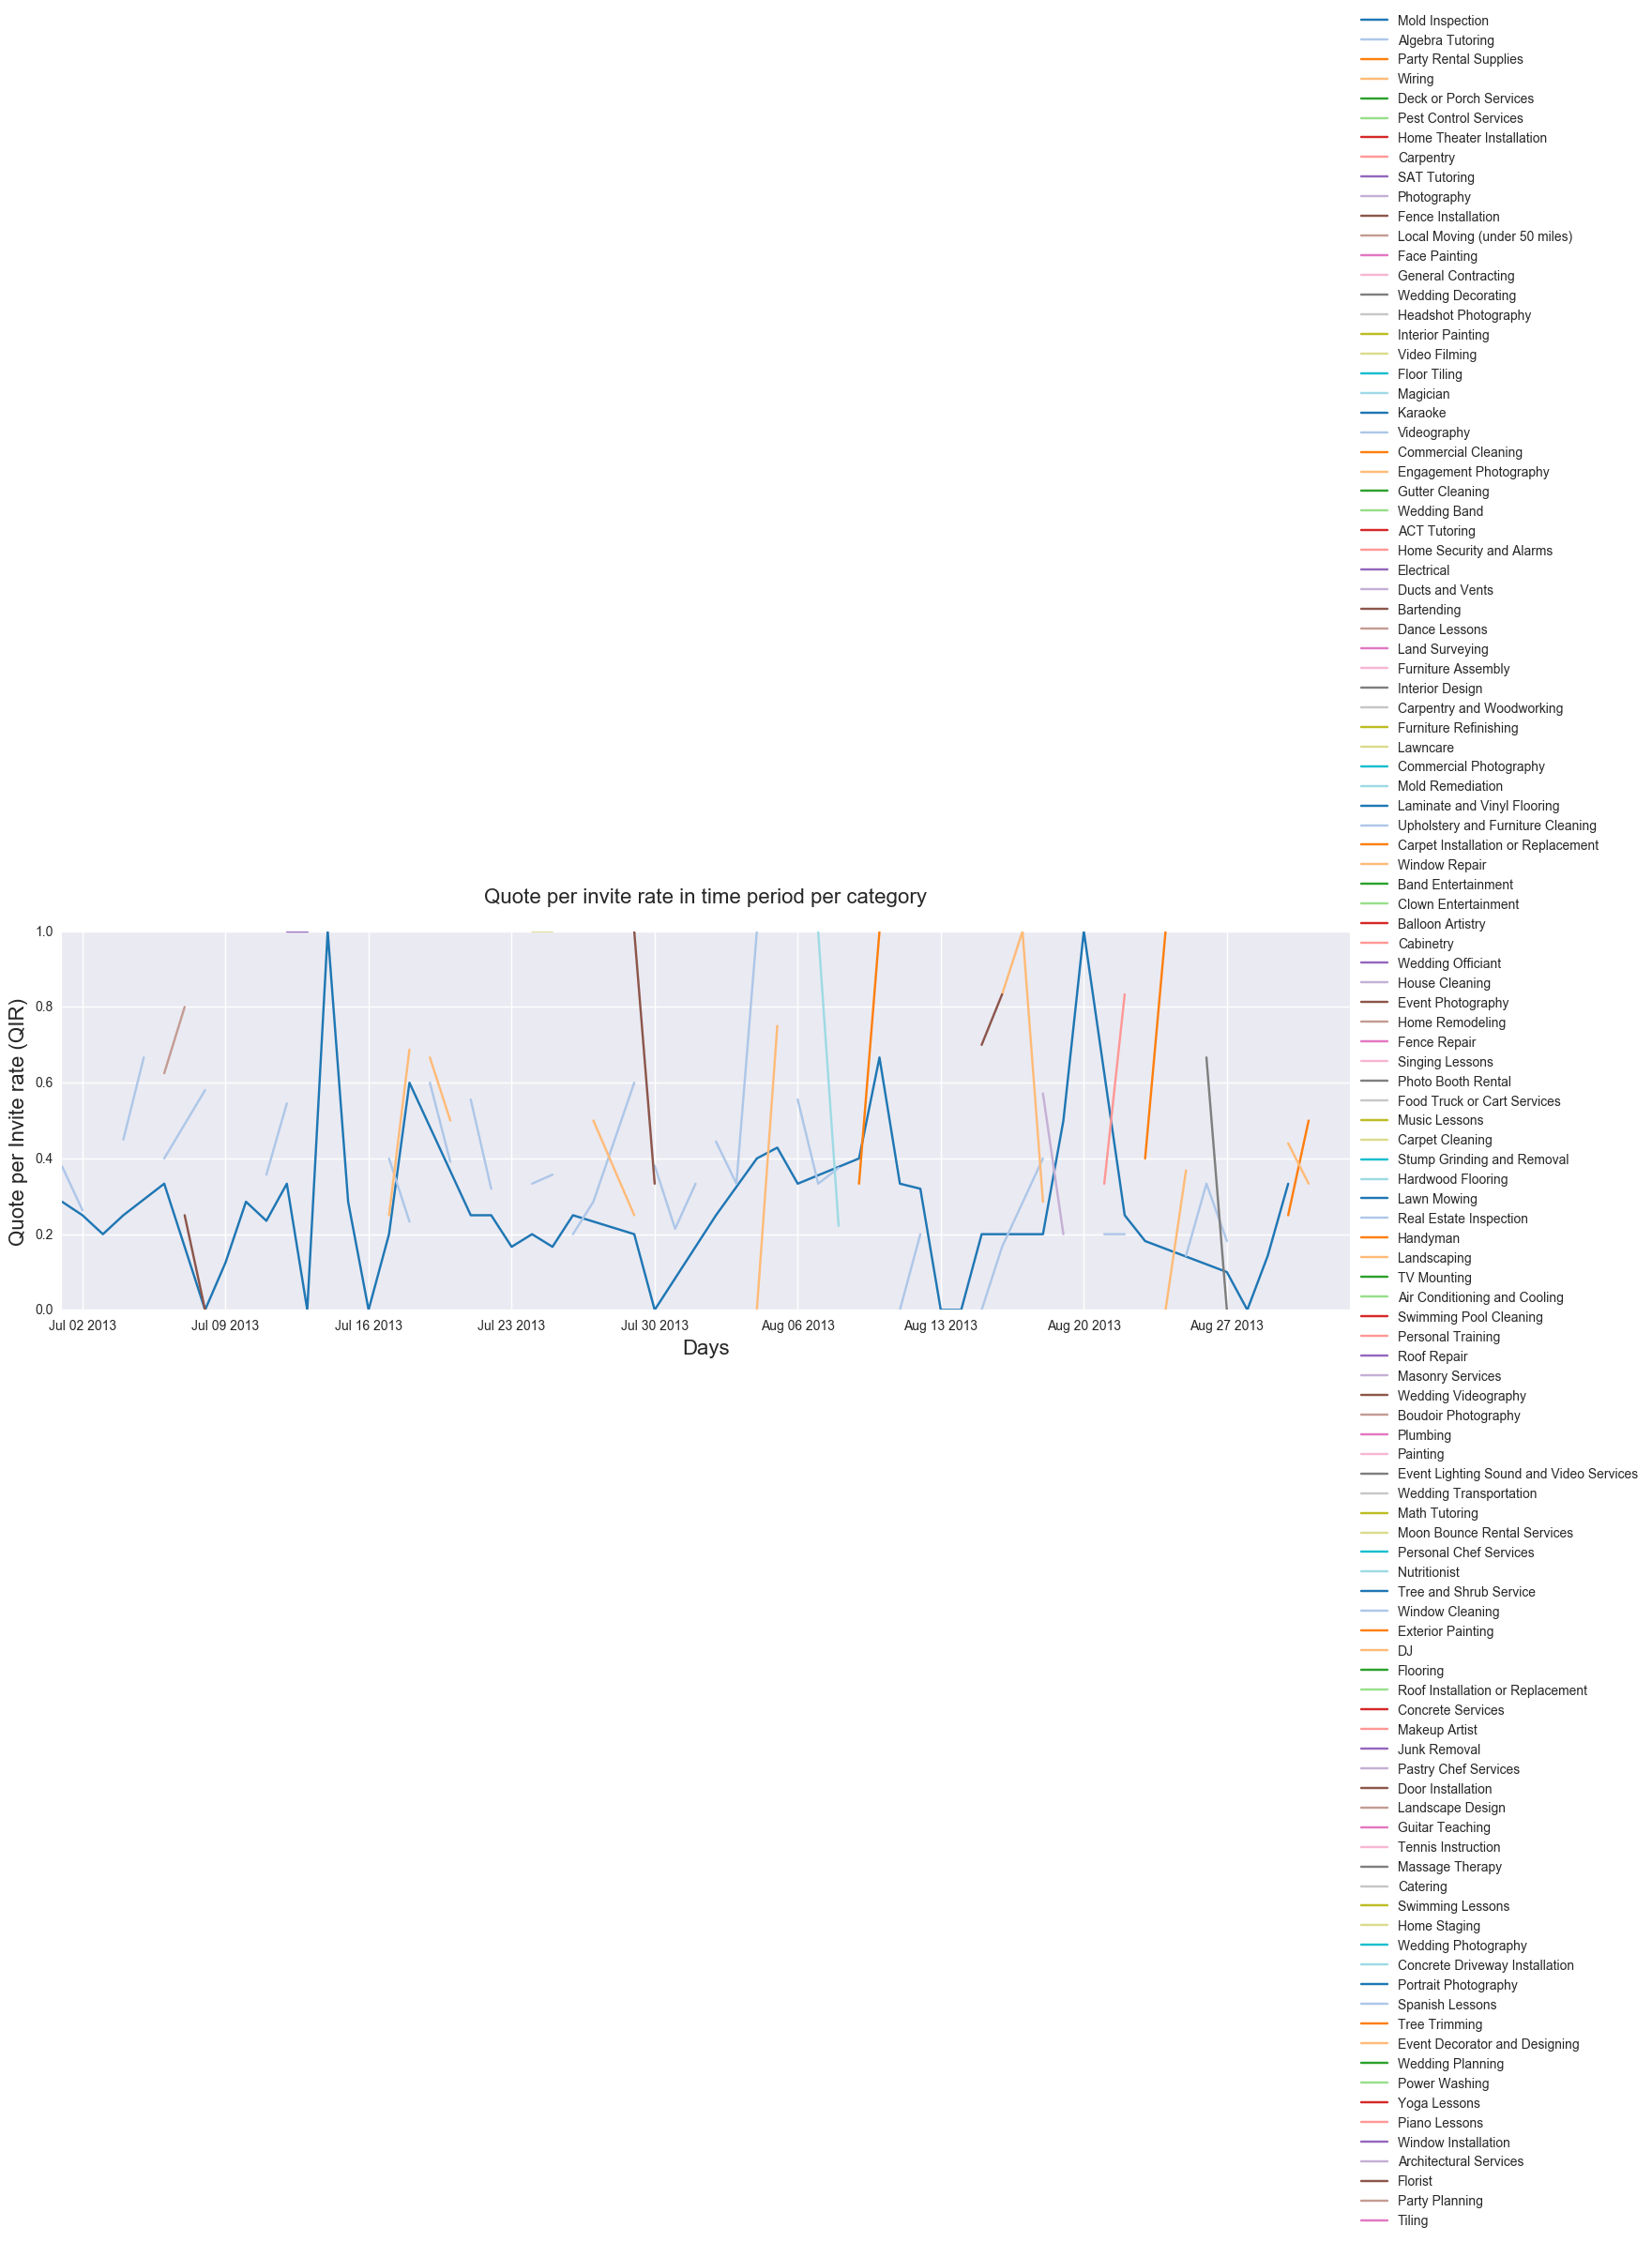

In [11]:
# draw continuous lines where data is available (change fmt='bo', to '-')
color_index = 0   
list_of_QIR_per_cat_dfs = get_quote_per_invite_rate_daily(data, categories = category_types)   

my_dpi = 192 #find your monitor dpi in http://www.infobyip.com/detectmonitordpi.php
# init the figure
fig_w, fig_h = 3400, 1000 # pixels
dpi=  100
fig = plt.figure(figsize=(float(fig_w)/float(my_dpi), float(fig_h)/float(my_dpi)), dpi=my_dpi, frameon=False)  
#print list_of_QIR_per_cat_dfs[0].head()
for i, cat in enumerate(category_types):
    # Plot each line separately with its own color.
    column_name = cat+'_QIR'
    cat_df = list_of_QIR_per_cat_dfs[i].sort_values(by=['datepoint'])#sub_df = df.copy().sort_values(by=['datepoint']) 
    line = plt.plot_date(cat_df['datepoint'],
            cat_df[column_name],
            '-', #for a continuous line, if we want to draw scatter plot of 'dots', use: #lw=2.5,
            color=color_sequence[color_index],
            #fmt='bo', 
            tz=None, xdate=True, 
            ydate=False, 
            label=cat)
    color_index +=1
    if color_index == len(color_sequence):
        color_index = 0

plt.title('Quote per invite rate in time period per category\n', fontsize=16, ha='center')

# Finally, save the figure as a PNG.
plt.ylabel("Quote per Invite rate (QIR)", fontsize=16)
plt.xlabel("Days", fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),shadow=True)
plt.savefig('quote-per-invite-rate-over-time-per-category_lines.png')# Do not use: generates error below on too large image: bbox_inches='tight', dpi=1000)
plt.show()

### Plotting quote rates per category, location and over time

sizes of final aggregate df:  113  categories and unique days:  64  and QIR different values:  186


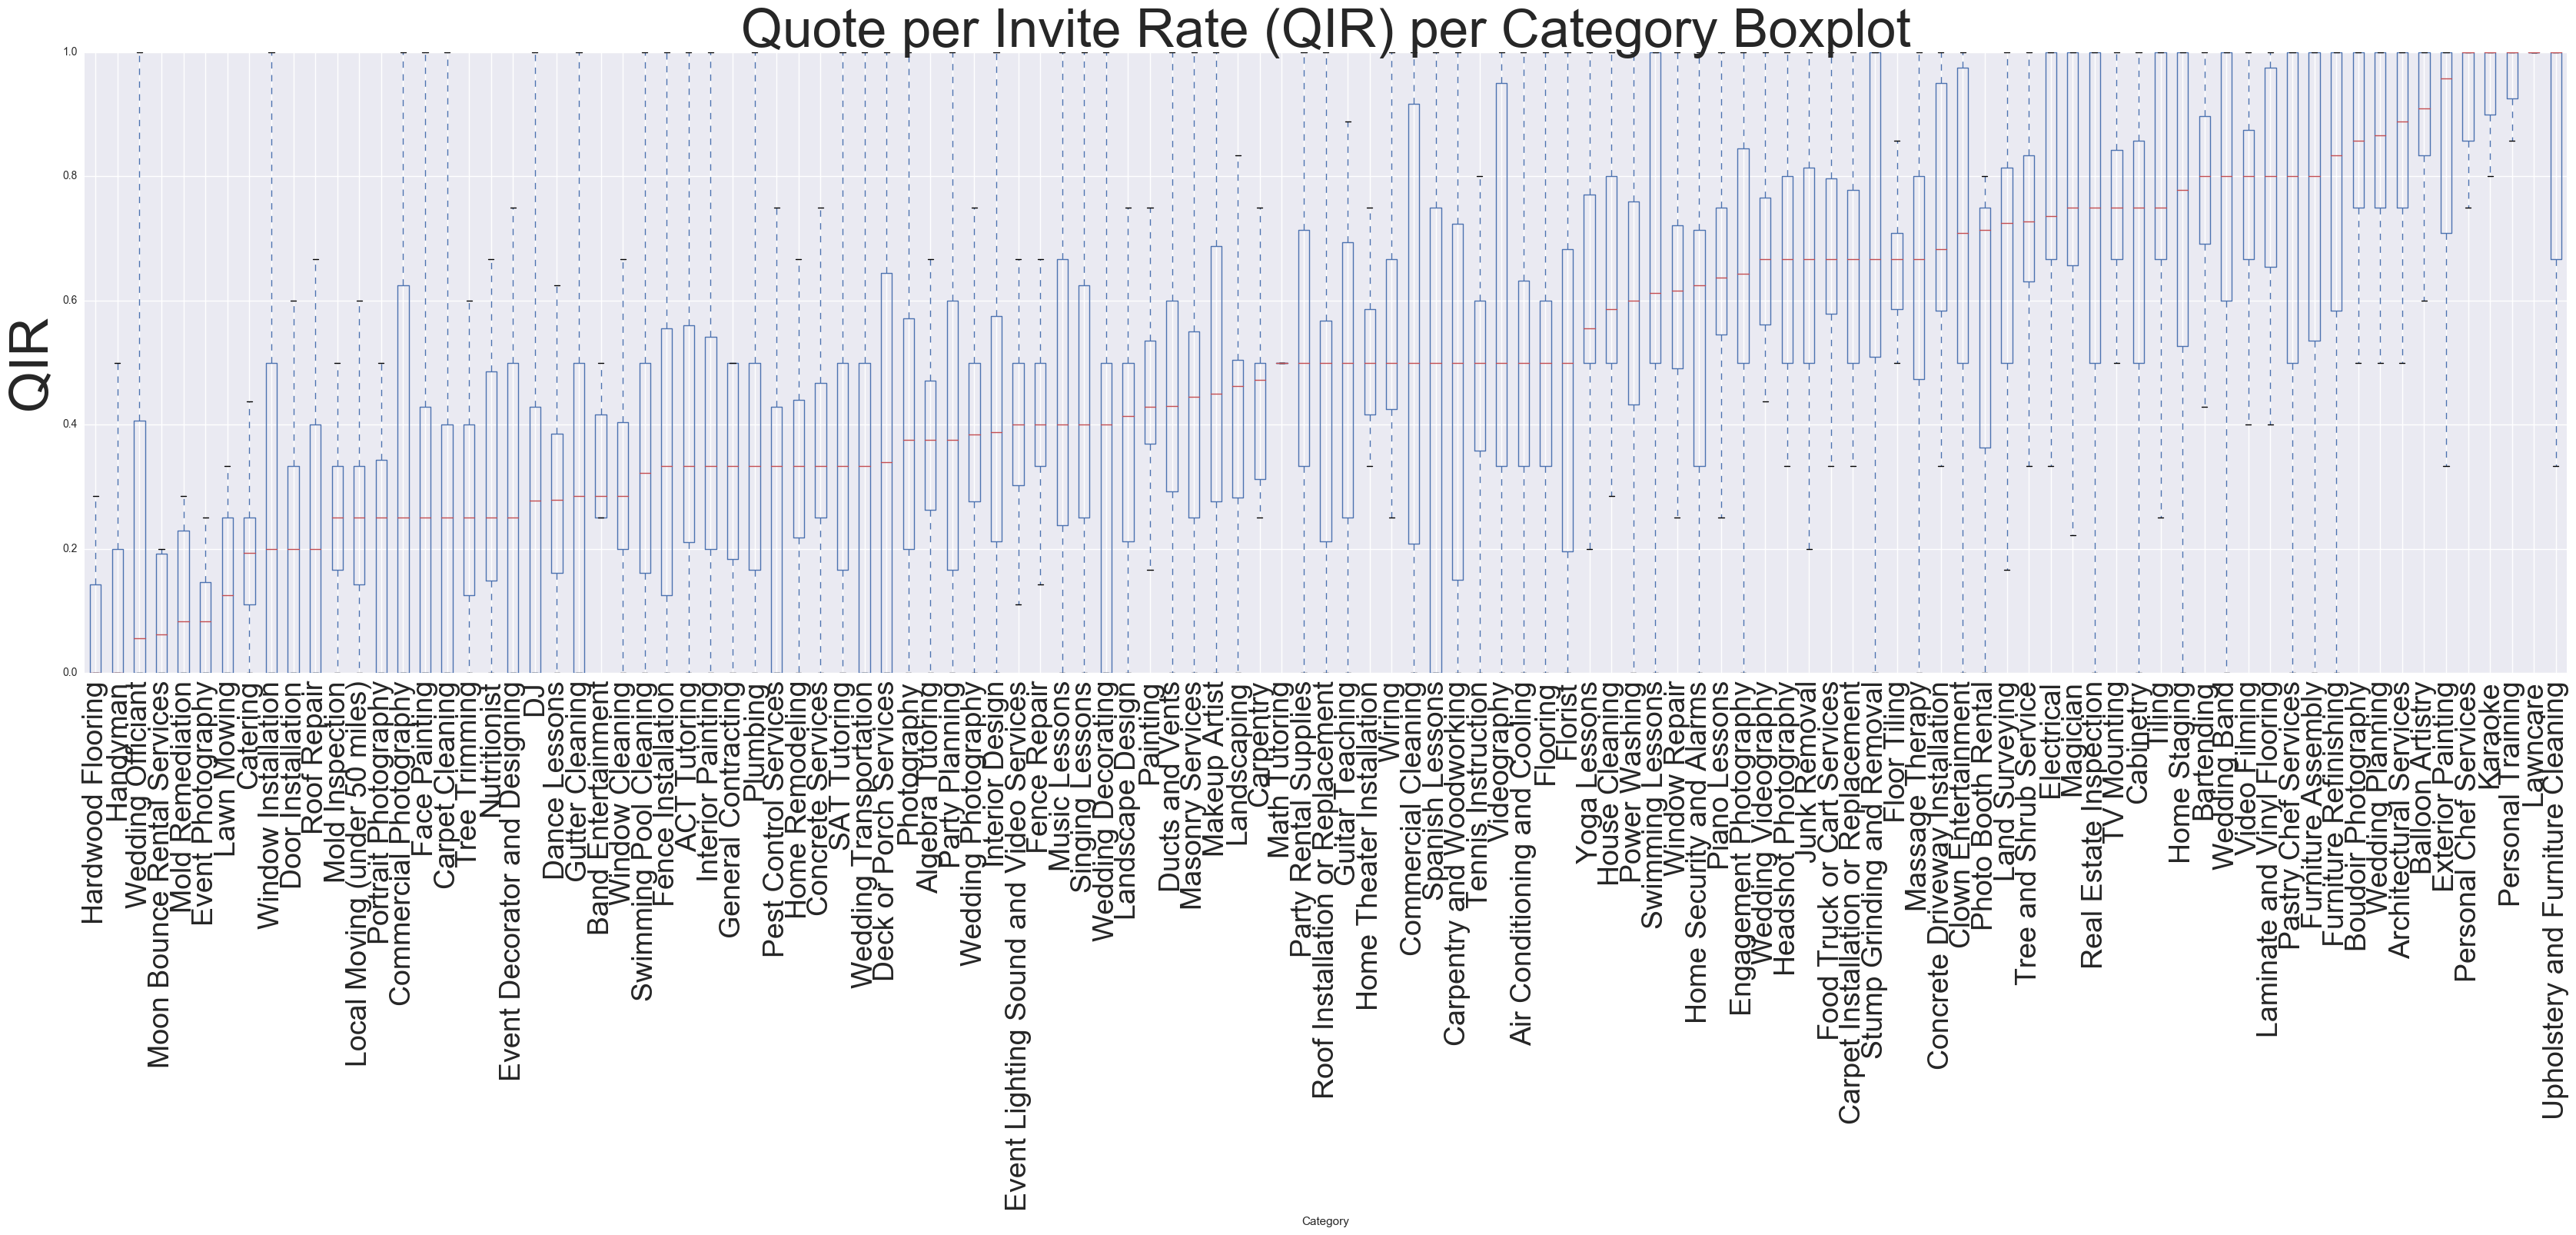

In [12]:
def boxplot_sorted(df, by, column):
    my_dpi = 192 #find your monitor dpi in http://www.infobyip.com/detectmonitordpi.php
    fig_w, fig_h = 8000, 2000
    fig = plt.figure(figsize=(float(fig_w)/float(my_dpi), float(fig_h)/float(my_dpi)), dpi=my_dpi, frameon=False)
    
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values() 
    ax = df2[meds.index].boxplot(rot=90)
    #ax.set_xlabel('xlabel',fontsize = 400) #xlabel
    
    plt.xticks(rotation=90, fontsize=27)
    plt.ylabel('QIR', fontsize=50)
    plt.xlabel('Category', rotation=0)#, fontsize=20)
    plt.title('Quote per Invite Rate (QIR) per Category Boxplot',fontsize=50)
    
    # ax.set_xticklabels(df.index, rotation=0)
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.savefig('boxplot_QIR_per_cat.png', bbox_inches='tight')
    plt.show()
    
#print len(alldata), alldata.head()
QIR_daily_per_cat = get_QIR_daily_per_category(alldata)
print "sizes of final aggregate df: ",QIR_daily_per_cat.category.nunique(), " categories and unique days: " , QIR_daily_per_cat.datepoint.nunique(), " and QIR different values: ",QIR_daily_per_cat.QIR.nunique()
boxplot_sorted(QIR_daily_per_cat, by=["category"], column="QIR")

In [13]:
#QIR_daily_per_cat.head()
py.iplot({
    'data': [Bar(x=QIR_daily_per_cat['category'], y=QIR_daily_per_cat.QIR)],
    'layout': { 
        'margin': {'b': 200}, # Make the bottom margin a bit bigger to handle the long text
        'xaxis': {'title': 'Category', 'tickangle': 40}, # Angle the labels a bit
        'yaxis': {'title': 'QIR'},
        'title': 'Quote per Invite Ratio per Category'
    }}, filename='QIR_per_category')

In [14]:
N = len(category_types)     # Number of boxes
x_data = category_types

# generate an array of rainbow colors by fixing the saturation and lightness of the HSL representation of colour 
# and marching around the hue. 
# Plotly accepts any CSS color format, see e.g. http://www.w3schools.com/cssref/css_colors_legal.asp.
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]

# Each box is represented by a dict that contains the data, the type, and the colour. 
# Use list comprehension to describe N boxes, each with a different colour and with different randomly generated data:
data = [{
    'y': QIR_daily_per_cat[QIR_daily_per_cat['category']==category_types[i]].QIR, #QIR_daily_per_cat.QIR,#QIR_daily_per_cat[QIR_daily_per_cat['category']==category_types[i]].QIR  #3.5*sin(pi * i/N) + i/N+(1.5+0.5*cos(pi*i/N))*random.rand(10), 
    'type':'box',
    'name': category_types[i],
    'marker':{'color': c[i]}
    } for i in range(N)]

# format the layout
layout = {'xaxis': {'showgrid':False,'zeroline':False, 'tickangle':60,'showticklabels':False},
          'yaxis': {'zeroline':False,'gridcolor':'white'},
          'paper_bgcolor': 'rgb(233,233,233)',
          'plot_bgcolor': 'rgb(233,233,233)',
          'xaxis':{'title': 'Category', 'tickangle': 40},
          'margin': {'b': 200}, # Make the bottom margin a bit bigger to handle the long text
          'yaxis':{'title': 'QIR'},
          'title': 'QIR variability per category',
          #'showlegend':False
          }
#py.iplot(data)#, layout, filename='QIR_box_plot_over_categories')
py.iplot({'data': data, 'layout': layout}, filename='QIR_box_plot_over_categories') 

In [15]:
datepoints= QIR_daily_per_cat.datepoint.unique()
N = len(datepoints)     # Number of boxes

# generate an array of rainbow colors by fixing the saturation and lightness of the HSL representation of colour 
# and marching around the hue. 
# Plotly accepts any CSS color format, see e.g. http://www.w3schools.com/cssref/css_colors_legal.asp.
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]

# Each box is represented by a dict that contains the data, the type, and the colour. 
# Use list comprehension to describe N boxes, each with a different colour and with different randomly generated data:
data = [{
    'y': QIR_daily_per_cat[QIR_daily_per_cat['datepoint']==datepoints[i]].QIR, #QIR_daily_per_cat.QIR,#QIR_daily_per_cat[QIR_daily_per_cat['category']==category_types[i]].QIR  #3.5*sin(pi * i/N) + i/N+(1.5+0.5*cos(pi*i/N))*random.rand(10), 
    'type':'box',
    'name': datepoints[i],
    'marker':{'color': c[i]}
    } for i in range(int(N))]

# format the layout
layout = {'xaxis': {'showgrid':False,'title': 'Individual days', 'zeroline':False, 'tickangle':40,'showticklabels':True},
          'yaxis': {'zeroline':False,'gridcolor':'white','title': 'QIR'},
          'title': 'QIR variability over time',
          'margin': {'b': 200}, # Make the bottom margin a bit bigger to handle the long text
          'paper_bgcolor': 'rgb(233,233,233)',
          'plot_bgcolor': 'rgb(233,233,233)',
          }
#py.iplot(data)#, layout, filename='QIR_box_plot_over_time')
py.iplot({'data': data, 'layout': layout}, filename='Requests_per_category') 

### Conclusion
In order to give better understanding on whether the trends on quote per invite rate increases or lowers over time, we would need a min. of 1 year wide data to be able to assess the trends and account for seasonal effects such as vacations (good for trips but also for repairs and home renovations), career transition periods, and any other temporal random effects. 

Looking at the variability of QIR per category in the plot above, we can see the lowest QIR categories, but also those with higher variability (largest area boxes). These are the categories to study closer, dig more into, and find if we are reaching enough public, having enough (quality) service provider offers, or invest more in marketing. 


### Discussion

Some projects to dig more into the data and find root causes/areas for improvement/experimentation:

Project Proposal 1: I would work on an algorithm to improve semantic alignment between consumers and service providers, and perform an experiment to find if improving the quality and reducing the quantity of quote offers to keep the most significative top N% or top T service matches, the average quote rate improves accross most categories and cities. (T could be T defined by the service provider/requester on his profile). One hypothesis to try this experiment is that users in cities with lots of service providers may afford higher quality services or may require higher quality/standars/variability of (niche) services, for instance.

I would perform an A/B test to allow for all natural matching requests that happen to invite service 
providers to give a quote in the control group, and allow only high aligned (high degree of matching in terms of 
the semantic meaning of the task required (fully coupled using, e.g. ontological alignment technologies [1]). This experiment could help finding if a filtered quality matching of requests improves the engagement and continued used of the matchmaking online platform from both parts. A Chi-squared test would assess if the average quote rate difference produces a statistically significant improvement that is practically significant for the company to deploy as part of the whole service matching algorithm. 
Engagement (e.g. visits to the site per week per user), as well as weekly revenue are other crucial metrics to monitor
while optimizing for a value of the threshold k while maximizing the quote rate that actually ends up being a  successfull service transaction. If we call this metric success rate (SR), SR would assess the quality of service matching algorithm A vs matching algorithm B:

SR = #transactions_completed / #quotes_offered

This experiment could be applied to those users overpassing a threshold of more than k matches a day, to improve over service alignment quality versus quantity. One could hypothesize that reducing the cognitive and work load of processing too many (irrelevant) offers may lead both parts in the company to abandon the system (service providers for not being able to handle too many requests and service requesters for not being able to find a matching service that fullfill their needs). 

Project Proposal 2:
I would launch a series of e.g. 5 A/B tests or multi-arm bandits of experiments paired with our control (current matching algorithm) group to find the optimal offer value of m messages to send per day. By limiting the matches for which we present a quote offer to the top m quality service match pairs, and by using a Pareto curve (**), we could find the optimal value of m for which:
<li> The matchmaking company can maximize revenue in terms of Success Rate SR (transactions/quotes made) and quote per invite (QIR) rate
<li> Service requesters minimize messages (the hassle of dealing with the cognitive load of deciding which service provider to choose from) while maximizing transactions. Since users already have Google, the matchmaking company's match should be personalized, meaningful and adequate to the request by offering only matches that highly match their demands (gotten by implicit or explicit feedback). 
<li> Service providers can balance their work load and not make the usage of the matchmaking company an overwhelming experience by receiving too many quotes offered but not too little either.

### APPENDIX (bibliography references)
[1] Following similar manner to ontology matching and my article http://tucs.fi/publications/view/?pub_id=cSaDxSuLiPo12a

[2] Pareto Optimality is a concept used in economics to model the efficiency and resource allocation problems. An allocation is said to be Pareto optimal if there is no other allocation that’s better than the current allocation, i.e., there’s no other situation in which some individual in the group is better off and no individual is worse off. This would find the optimal value of m for both parts to win (for consumers to save time deciding which service to pay for, for service providers to efficiently allocate all their resources fast, and for the company to maximize profit).

[3] Tolerance interval (TI): tolerance intervals are used when having sampled data, we want to predict a range of likely outcomes. A tolerance interval is a range that is likely to contain a specified proportion of the population. To generate tolerance intervals, we must specify both the proportion of the population and a confidence level. The confidence level is the likelihood that the interval actually covers the proportion. Because TI work with a sample, TI have Confidence Intervals. http://blog.minitab.com/blog/adventures-in-statistics/when-should-i-use-confidence-intervals-prediction-intervals-and-tolerance-intervals

[4] Confidence Intervals (CI) plots with Pandas: http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-23-point.html
http://pandas.pydata.org/pandas-docs/version/0.15.2/visualization.html

[5] CI serve as good estimates of the real population parameter and they can be used to assess the 
precision of the sample estimate. For a specific variable, a narrower confidence interval suggests a more precise 
estimate of the population parameter than a wider one. If we can conclude our results are statistically significant, both P Values and Confidence Intervals will agree: it is conventional to use a significance level alpha of 0.05, for which the corresponding confidence level is 95% and:
<li>If the P value is less than your significance (alpha) level, the hypothesis test is statistically significant.
<li>If the confidence interval does not contain the null hypothesis value, the results are statistically significant.
<li>If the P value is less than alpha, the confidence interval will not contain the null hypothesis value.